## Group 25 members: Alfred Kjeller & William Gerle

# Imports

In [24]:
# Supress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Imports
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

# Load data

In [25]:
from sklearn.model_selection import train_test_split

# Read the TSV files.
data_train = pd.read_csv('a3_train_final.tsv', sep = '\t', header = None)
data_test = pd.read_csv('a3_test_final.tsv', sep = '\t', header = None)

#Add headers
data_train.columns = ['Label', 'Text']
data_test.columns = ['Label', 'Text']

# Shuffle the datasets.
data_train = data_train.sample(frac=1.0, random_state=0)
data_test = data_test.sample(frac=1.0, random_state=0)

# Calculate and print annotation agreement
MajorityVotes = 0
UniformVotes = 0
OppositeVotes = 0

for i, row in data_train.iterrows():
    if(row['Label'].count('1') + row['Label'].count('-1')) == 0:
        UniformVotes += 1

    elif(row['Label'].count('0') + row['Label'].count('-1')) == 0:
        UniformVotes += 1

    elif(row['Label'].count('1') > row['Label'].count('0') + row['Label'].count('-1')):
        MajorityVotes += 1
        
    elif(row['Label'].count('0') > row['Label'].count('1') + row['Label'].count('-1')):
        MajorityVotes += 1
    
    if(row['Label'].count('0') > 0 and row['Label'].count('1') > 0):
        OppositeVotes +=1
    
print('The number of annotation where annotaters have fully agreed are {}. In percentage this is {} %'.format(UniformVotes, round(UniformVotes/len(data_train)*100,2)))
print('The number of annotation where the majority of annotaters have agreed are {}. In percentage this is {} %'.format(MajorityVotes+UniformVotes, round((MajorityVotes+UniformVotes)/len(data_train)*100,2)))
print('The number of annotation where the annotaters have though the opposite are {}. In percentage this is {} %'.format(OppositeVotes, round(OppositeVotes/len(data_train)*100,2)))

# Clean annotations
for i, row in data_train.iterrows():
    values = row['Label'].split('/')
    if values.count('0') == len(values):
        data_train.at[i, 'Label'] = '0'
    elif values.count('1') == len(values):
        data_train.at[i, 'Label'] = '1'
    else:
        data_train.at[i, 'Label'] = None

# Remove missing values
data_train = data_train.dropna()

# Split into input part X and output part Y.
X = data_train.drop('Label', axis=1)
X_test = data_test.drop('Label', axis=1)

# Add ouput to dataframe
Y = data_train['Label']
Y_test = data_test['Label']

data_train.head(n = 10)


The number of annotation where annotaters have fully agreed are 14357. In percentage this is 84.91 %
The number of annotation where the majority of annotaters have agreed are 15245. In percentage this is 90.16 %
The number of annotation where the annotaters have though the opposite are 1782. In percentage this is 10.54 %


,Label,Text
7939,1,"I’m not anti vaccine, i’m anti forcing people ..."
15715,1,date idea: go get vaccinated together https://...
7182,1,In my country only health workers are receivin...
2952,1,Got my first shot today in Georgia!
591,0,"All of this hasn’t been studied long enough, t..."
3571,1,I Cleared My Pfizer Dose-2 Last Week... Thankf...
4036,1,"I consider myself lucky and blessed , not only..."
4992,1,I just got my vaccine! No side effects as of yet!
9126,0,"My mother told me not to get vaccinated, she h..."
7314,0,It doesn't help that RNA vaccines crash your l...


# Classifiers

In [26]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

# Helper methods
def classify_count_vectorizer(models, title):
    count_vectorizer = CountVectorizer(token_pattern=r'\w+')
    count_vectorizer.fit(X.Text)
    x_encoded = count_vectorizer.transform(X.Text)
    for i, model in enumerate(models):
        fit_and_predict_model(model, x_encoded, Y, title[i])

def classify_tfidf_vectorizer(models, title):
    tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\w+')
    tfidf_vectorizer.fit(X.Text)
    x_encoded = tfidf_vectorizer.transform(X.Text)
    for i, model in enumerate(models):
        fit_and_predict_model(model, x_encoded, Y, title[i])

def classify_tfidf_vectorizer_stop_words(models, title):
    tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\w+', max_df=0.90, min_df=3)
    tfidf_vectorizer.fit(X.Text)
    x_encoded = tfidf_vectorizer.transform(X.Text)
    for i, model in enumerate(models):
        fit_and_predict_model(model, x_encoded, Y, title[i])


def classify_tfidf_vectorizer_lemma(models, title):
    tfidf_vectorizer = TfidfVectorizer(binary=False, tokenizer=LemmaTokenizer())
    tfidf_vectorizer.fit(X.Text)
    x_encoded = tfidf_vectorizer.transform(X.Text)
    for i, model in enumerate(models):
        fit_and_predict_model(model, x_encoded, Y, title[i])

def fit_and_predict_model(model, x, y, title):
    print('Validation accuracy: {:.2f} %    {}'.format(round(cross_val_score(model, x, y).mean() * 100, 2), title))

In [27]:
#Imports and downloading nltk_data
import nltk         
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('wordnet')

#Lemmanizer class
class LemmaTokenizer:
    def __init__(self):
         self.wnl = WordNetLemmatizer()
         self.tokenizer = nltk.RegexpTokenizer(r"\w+")
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in self.tokenizer.tokenize(doc)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# Testing of different models and parameters

classify_count_vectorizer([BernoulliNB(), MultinomialNB(), LinearSVC(random_state=0)], ['BNB with CountVectorizer', 'MNB with CountVectorizer', 'SVC with CountVectorizer'])

print("")

classify_tfidf_vectorizer([BernoulliNB(), MultinomialNB(), LinearSVC(random_state=0)], ['BNB with TfidfVectorizer', 'MNB with TfidfVectorizer', 'SVC with TfidfVectorizer'])

print("")

classify_tfidf_vectorizer([BernoulliNB(fit_prior=False), MultinomialNB(fit_prior=True)], ['BNB with TfidfVectorizer fit_prior false', 'MNB with TfidfVectorizer fit_prior false'])

print("")

classify_tfidf_vectorizer_stop_words([BernoulliNB(), MultinomialNB(), LinearSVC(random_state=0)], ['BNB with TfidfVectorizer stop words', 'MNB with TfidfVectorizer stop words', 'SVC with TfidfVectorizer stop words'])

print("")

classify_tfidf_vectorizer_lemma([BernoulliNB(), MultinomialNB(), LinearSVC(random_state=0)], ['BNB with TfidfVectorizer lemma', 'MNB with TfidfVectorizer lemma', 'SVC with TfidfVectorizer lemma'])

print("")

classify_tfidf_vectorizer_lemma([LinearSVC(dual=False, random_state=0), LinearSVC(loss='hinge', random_state=0)], ['LinearSVC dual false lemma', 'LinearSVC hinge lemma'])

print("")

classify_tfidf_vectorizer_lemma([LinearSVC(C=1, random_state=0), LinearSVC(C=2, random_state=0), LinearSVC(C=5, random_state=0), LinearSVC(C=10, random_state=0)], ['LinearSVC C=1', 'LinearSVC C=2', 'LinearSVC C=5', 'LinearSVC C=10'])



Validation accuracy: 81.90 %    BNB with CountVectorizer
Validation accuracy: 82.89 %    MNB with CountVectorizer
Validation accuracy: 82.87 %    SVC with CountVectorizer

Validation accuracy: 81.90 %    BNB with TfidfVectorizer
Validation accuracy: 83.58 %    MNB with TfidfVectorizer
Validation accuracy: 84.53 %    SVC with TfidfVectorizer

Validation accuracy: 81.90 %    BNB with TfidfVectorizer fit_prior false
Validation accuracy: 83.58 %    MNB with TfidfVectorizer fit_prior false

Validation accuracy: 81.69 %    BNB with TfidfVectorizer stop words
Validation accuracy: 83.66 %    MNB with TfidfVectorizer stop words
Validation accuracy: 84.36 %    SVC with TfidfVectorizer stop words

Validation accuracy: 81.88 %    BNB with TfidfVectorizer lemma
Validation accuracy: 83.68 %    MNB with TfidfVectorizer lemma
Validation accuracy: 84.82 %    SVC with TfidfVectorizer lemma

Validation accuracy: 84.82 %    LinearSVC dual false lemma
Validation accuracy: 84.60 %    LinearSVC hinge lemma



Test accuracy 87.64 %
SVC True positive rate: 87.53%  True negative rate: 87.76%  Total accuracy: 87.64%


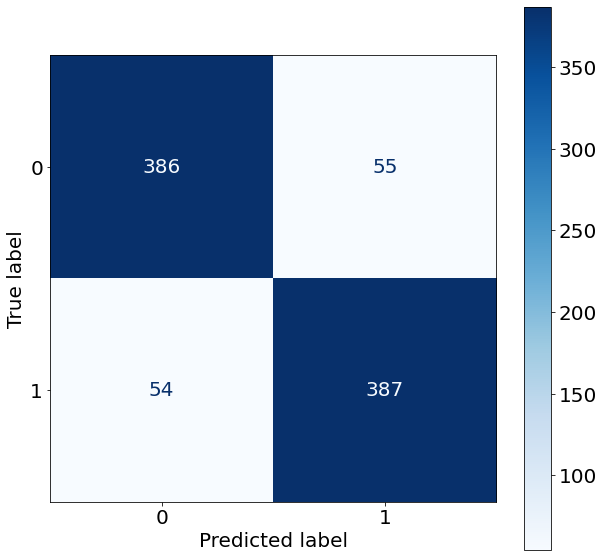

In [29]:
from sklearn.metrics import accuracy_score

# Evaulate final model
tfidf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer())
tfidf_vectorizer.fit(X.Text)
x_encoded = tfidf_vectorizer.transform(X.Text)
x_encoded_test = tfidf_vectorizer.transform(X_test.Text)
clf = LinearSVC(random_state=0)
clf.fit(x_encoded, Y)
y_pred = clf.predict(x_encoded_test)

print('Test accuracy',round(accuracy_score(Y_test.to_numpy().astype(str), y_pred) * 100, 2), '%')

res = metrics.confusion_matrix(Y_test.to_numpy().astype(str), y_pred)
tpr = round((res.item(0) / (res.item(0) + res.item(1))) * 100, 2)
tnr = round((res.item(3) / (res.item(2) + res.item(3))) * 100, 2)
acc = round(((res.item(0) + res.item(3)) / (res.item(0) + res.item(1) + res.item(2) + res.item(3))) * 100, 2)
print("{} True positive rate: {}%  True negative rate: {}%  Total accuracy: {}%".format('SVC', tpr, tnr, acc))

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 20})
matrix = metrics.plot_confusion_matrix(clf, x_encoded_test, Y_test.to_numpy().astype(str), cmap=plt.cm.Blues)
plt.show(matrix)
plt.show()



In [30]:
# Take out the most important features
feature = pd.DataFrame()
feature['Word'] = tfidf_vectorizer.get_feature_names()
feature['Weight'] = clf.coef_.ravel()
feature = feature.sort_values(by=['Weight'], ascending=False)
pd.options.display.float_format = '{:.5f}'.format
print(feature.head(n=5), '\n')
print(feature.tail(n=5))

              Word  Weight
11343      vaxxers 2.26200
9379       selfish 2.17216
947    antivaxxers 1.96807
6357       logical 1.96272
10710        today 1.95910 

               Word   Weight
10503          term -2.43513
8051         poison -2.72135
3949   experimental -2.79419
7192          never -2.94881
7284            not -3.27310


In [31]:
# Print out wrongfull predictions
for i, pred in enumerate(y_pred):
    if pred != Y_test.to_numpy().astype(str)[i]:
        print(pred)
        print(X_test.to_numpy()[i])

1
['My mom died a few days after taking the 2nd vaccine shot, this last Saturday March 27th. I’m completely lost. She was just fine']
0
['the vaccine is developed by a trusted company']
1
["I'd rather take my supplements...... you can have my share of the vaccine"]
0
['That shot was so quick and smooth']
0
['I took the first Moderna vaccine 27 days ago. 14 days ago, my husband test positive for C-19 after he became symptomatic . My grandson and I tested five days later after my husband experienced symptoms. My grandson tested positive. I tested negative. I’am taking the second shot tomorrow! I’am a firm believer that the vaccine works!']
0
['I think they will probably make limitations for your daily life if you don’t take the vaccine so you will be kind of forced to take it :/']
0
['have been vaccinated and think it’s not bad']
0
['I had mine about two months now I don’t have no side effects thank god']
1
['Yeah it’s dangerous for us to think outside public opinion... that means we’re 